In [27]:
# Install Java, Spark, and findspark
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar xf spark-3.5.0-bin-hadoop3.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"


In [28]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").appName("LogAnalysis").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")


In [29]:
from google.colab import files
uploaded = files.upload()


Saving web log analysis.csv to web log analysis.csv


In [30]:
df = spark.read.option("header", True).option("inferSchema", True).csv("/content/web log analysis.csv")
df.printSchema()
df.show(5)


root
 |-- timestamp: timestamp (nullable = true)
 |-- ip: string (nullable = true)
 |-- method: string (nullable = true)
 |-- url: string (nullable = true)
 |-- status: integer (nullable = true)
 |-- user_agent: string (nullable = true)

+-------------------+-----------+------+----------+------+--------------------+
|          timestamp|         ip|method|       url|status|          user_agent|
+-------------------+-----------+------+----------+------+--------------------+
|2025-07-19 10:00:00|192.168.1.1|   GET|     /home|   200|         Mozilla/5.0|
|2025-07-19 10:01:00|192.168.1.2|  POST|    /login|   401|         Mozilla/5.0|
|2025-07-19 10:02:00|203.0.113.5|   GET| /api/data|   200|         curl/7.68.0|
|2025-07-19 10:03:00|   10.0.0.1|DELETE|/api/order|   500|PostmanRuntime/7....|
|2025-07-19 10:04:00| 172.16.0.3|   GET|/dashboard|   200|         Mozilla/5.0|
+-------------------+-----------+------+----------+------+--------------------+
only showing top 5 rows



In [31]:
print("Total log entries:", df.count())


Total log entries: 120


In [32]:
df.groupBy("URL").count().orderBy("count", ascending=False).show(10, truncate=80)

+----------+-----+
|       URL|count|
+----------+-----+
|/dashboard|   26|
|     /home|   24|
| /products|   23|
|/api/order|   18|
|  /contact|   16|
| /api/data|    9|
|    /login|    3|
|   /logout|    1|
+----------+-----+



In [33]:
df.groupBy("status").count().orderBy("count", ascending=False).show()

+------+-----+
|status|count|
+------+-----+
|   200|   68|
|   404|   24|
|   401|    9|
|   500|    8|
|   201|    6|
|   503|    4|
|   403|    1|
+------+-----+



In [34]:
df.groupBy("IP").count().orderBy("count", ascending=False).show(10)

+--------------+-----+
|            IP|count|
+--------------+-----+
|  185.206.92.1|   19|
|      10.0.0.1|   18|
|    172.16.0.3|   16|
|   203.0.113.5|   15|
|67.219.144.123|   15|
|  198.51.100.4|   14|
|   192.168.1.1|   12|
|   192.168.1.2|   11|
+--------------+-----+



In [35]:
from pyspark.sql.functions import hour, to_timestamp

# Convert the 'timestamp' column to a timestamp and extract the hour
# The column is already timestamp type, so to_timestamp with just the column name is sufficient
df_with_time = df.withColumn("hour", hour("timestamp"))

# Group by hour and show the counts
df_with_time.groupBy("hour").count().orderBy("hour").show()

+----+-----+
|hour|count|
+----+-----+
|  10|   60|
|  11|   60|
+----+-----+



In [36]:
error_logs = df.filter(df.status.cast("int") >= 400)
error_logs.show(5)
print("Total error logs:", error_logs.count())

+-------------------+--------------+------+----------+------+--------------------+
|          timestamp|            ip|method|       url|status|          user_agent|
+-------------------+--------------+------+----------+------+--------------------+
|2025-07-19 10:01:00|   192.168.1.2|  POST|    /login|   401|         Mozilla/5.0|
|2025-07-19 10:03:00|      10.0.0.1|DELETE|/api/order|   500|PostmanRuntime/7....|
|2025-07-19 10:06:00|67.219.144.123|   GET| /api/data|   404|         curl/7.68.0|
|2025-07-19 10:09:00|   203.0.113.5|   GET|     /home|   503|PostmanRuntime/7....|
|2025-07-19 10:11:00|  185.206.92.1|  POST|    /login|   403|         Mozilla/5.0|
+-------------------+--------------+------+----------+------+--------------------+
only showing top 5 rows

Total error logs: 46


In [37]:
error_logs.groupBy("URL").count().orderBy("count", ascending=False).show(10, truncate=80)

+----------+-----+
|       URL|count|
+----------+-----+
|/dashboard|   12|
| /products|    8|
|/api/order|    6|
| /api/data|    6|
|  /contact|    6|
|     /home|    5|
|    /login|    3|
+----------+-----+



In [38]:
error_logs.groupBy("status").count().orderBy("count", ascending=False).show()

+------+-----+
|status|count|
+------+-----+
|   404|   24|
|   401|    9|
|   500|    8|
|   503|    4|
|   403|    1|
+------+-----+



In [39]:
top_urls = df.groupBy("URL").count().orderBy("count", ascending=False).limit(20)
top_urls.toPandas().to_csv("top_urls.csv", index=False)
from google.colab import files
files.download("top_urls.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

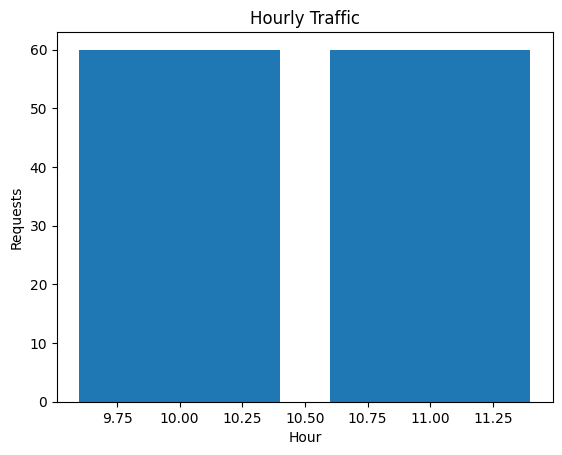

In [40]:
import matplotlib.pyplot as plt

traffic = df_with_time.groupBy("hour").count().orderBy("hour").toPandas()
plt.bar(traffic['hour'], traffic['count'])
plt.xlabel("Hour")
plt.ylabel("Requests")
plt.title("Hourly Traffic")
plt.show()


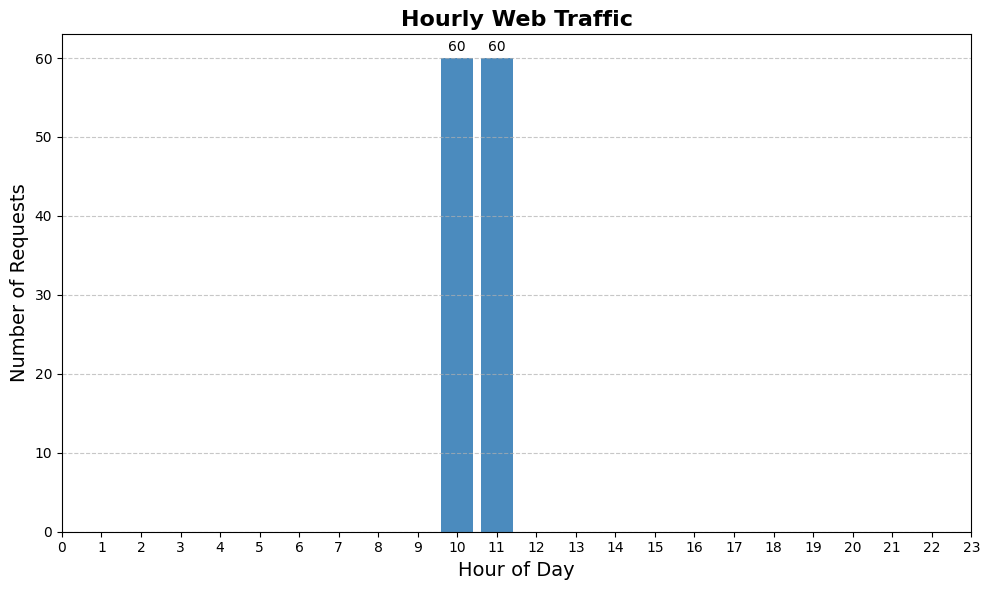

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Suppose traffic['hour'] is int 0-23
fig, ax = plt.subplots(figsize=(10,6))
bars = ax.bar(traffic['hour'], traffic['count'], color="#4b8bbe")

# Set x-axis as all 0-23 to show gaps as zeros if any hours are missing in the data
ax.set_xticks(np.arange(0, 24, 1))
ax.set_xticklabels(np.arange(0, 24, 1))
ax.set_xlabel("Hour of Day", fontsize=14)
ax.set_ylabel("Number of Requests", fontsize=14)
ax.set_title("Hourly Web Traffic", fontsize=16, fontweight='bold')
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Annotate bars
for bar in bars:
    height = bar.get_height()
    if height > 0:
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0,3), # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


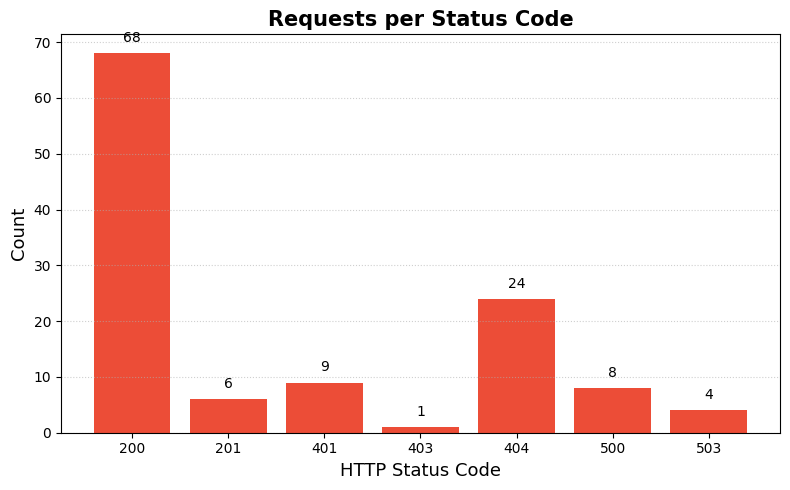

In [42]:
status_counts = df.groupBy("status").count().orderBy("status").toPandas()
plt.figure(figsize=(8,5))
plt.bar(status_counts['status'].astype(str), status_counts['count'], color="#ec4d37")
plt.xlabel("HTTP Status Code", fontsize=13)
plt.ylabel("Count", fontsize=13)
plt.title("Requests per Status Code", fontsize=15, fontweight='bold')
plt.grid(axis='y', linestyle=':', alpha=0.6)
for idx, val in enumerate(status_counts['count']):
    plt.text(idx, val+2, str(val), ha='center', fontsize=10)
plt.tight_layout()
plt.show()


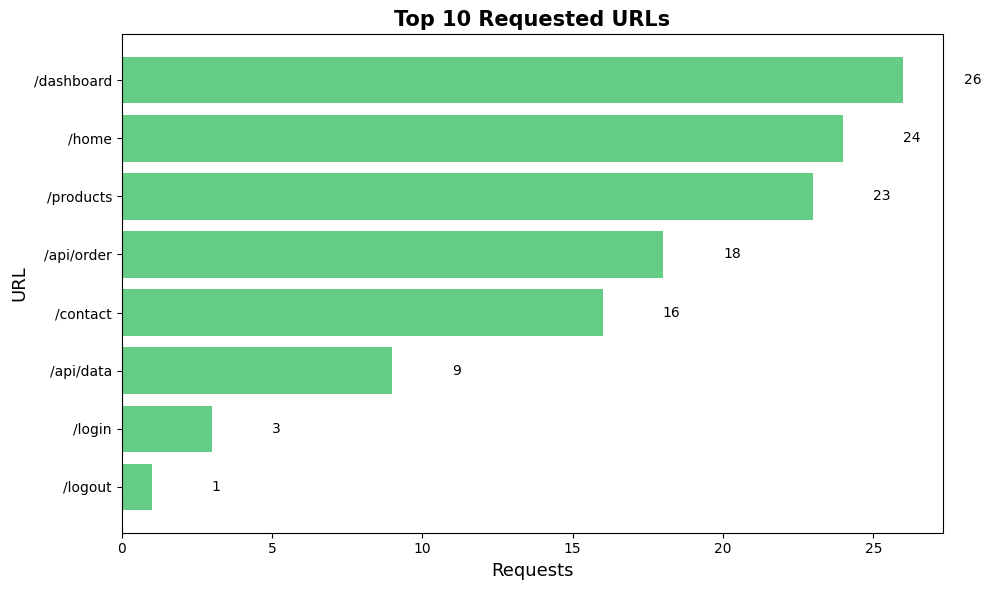

In [43]:
top_urls = df.groupBy("url").count().orderBy("count", ascending=False).limit(10).toPandas()
plt.figure(figsize=(10,6))
bars = plt.barh(top_urls['url'], top_urls['count'], color="#64cc85")
plt.xlabel("Requests", fontsize=13)
plt.ylabel("URL", fontsize=13)
plt.title("Top 10 Requested URLs", fontsize=15, fontweight='bold')
plt.gca().invert_yaxis()
for bar in bars:
    plt.text(bar.get_width()+2, bar.get_y()+bar.get_height()/2, str(int(bar.get_width())), va='center')
plt.tight_layout()
plt.show()


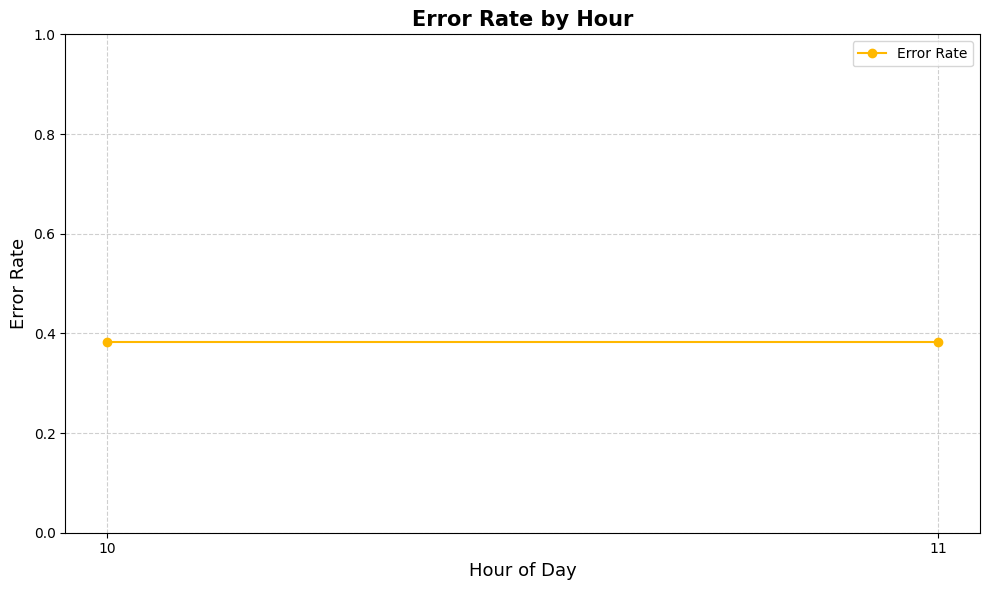

In [44]:
from pyspark.sql.functions import col, coalesce, lit

# Reuse df_with_time which already has the 'hour' column extracted using PySpark
# Filter for error logs (status >= 400) using PySpark
error_df_spark = df_with_time.filter(col('status') >= 400)

# Calculate total requests per hour using PySpark
total_requests_per_hour_spark = df_with_time.groupBy('hour').count().orderBy('hour')

# Calculate error requests per hour using PySpark
error_requests_per_hour_spark = error_df_spark.groupBy('hour').count().orderBy('hour')

# Join the two DataFrames to calculate the error rate
# Use a left outer join from total requests to error requests to include hours with no errors
error_rate_by_hour_spark = total_requests_per_hour_spark.join(
    error_requests_per_hour_spark,
    on='hour',
    how='left_outer'
).select(
    total_requests_per_hour_spark.hour,
    (coalesce(error_requests_per_hour_spark['count'], lit(0)) / total_requests_per_hour_spark['count']).alias('error_rate')
).orderBy('hour')

# Convert the result to pandas for plotting
error_by_hour_pandas = error_rate_by_hour_spark.toPandas()

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(error_by_hour_pandas['hour'], error_by_hour_pandas['error_rate'], marker='o', color='#ffb800', label='Error Rate')
plt.xlabel("Hour of Day", fontsize=13)
plt.ylabel("Error Rate", fontsize=13)
plt.title("Error Rate by Hour", fontsize=15, fontweight='bold')
plt.ylim(0, 1)
plt.xticks(error_by_hour_pandas['hour']) # Ensure all hours with data are shown on x-axis
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

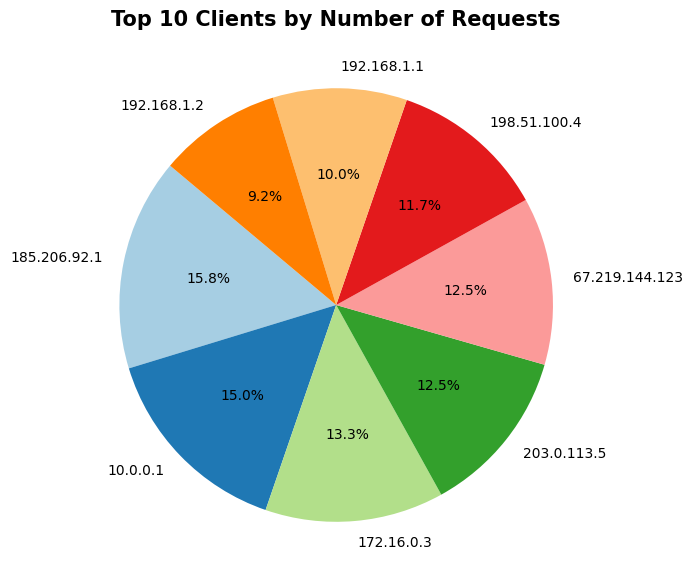

In [45]:
top_ips = df.groupBy("ip").count().orderBy("count", ascending=False).limit(10).toPandas()
plt.figure(figsize=(7,7))
plt.pie(top_ips['count'], labels=top_ips['ip'], autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title("Top 10 Clients by Number of Requests", fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()
